In [1]:
# This code explorer kinematic profile of MW, M31 merger remenant,
# by calculates velocity dispersion and rotation curve. 

In [11]:
# import all modules needed 
import numpy as np
import astropy.units as u
from astropy.constants import G

# import plotting modules
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# my modules
from ReadFile import Read
from CenterOfMass import CenterOfMass
from MassProfile import MassProfile
from Lab7 import RotateFrame, density_contour

In [2]:
# create center of mass object for MW and M31, snapshot #560 corresponding 8.0 Gyrs from now

# MW
time_MW, n_MW, data_MW = Read("MW_560.txt")

# M31
time_M31, n_M31, data_M31 = Read("M31_560.txt")

In [3]:
# combine those into single data set 
# numpy.concatenate() 
# https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html 

data = np.concatenate((data_MW, data_M31))

index = np.where(data_MW['type'] != 3 )
remnants = data[index] 

In [4]:
print(data_M31.shape)
print(data_MW.shape)
print(remnants.shape)

(94500,)
(67500,)
(62500,)


In [5]:
# Create new text file with combined particles

filename = "Remnant.txt"
time = 7999.99999
n_particles = len(remnants)

with open(filename, 'w') as f:
    # Custom metadata lines (exact format as requested)
    f.write(f"Time   {time:.5f}\n")
    f.write(f"Total       {n_particles}\n")
    f.write("mass in 1e10,  x, y, z, in kpc and vx, vy, vz in km/s\n")
    
    # Header line
    header = "{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}".format(
        'type', 'm', 'x', 'y', 'z', 'vx', 'vy', 'vz')
    f.write(header + "\n")
    
    # Data rows
    np.savetxt(f, remnants, fmt="%11.3f"*8)


In [6]:
time, n, data = Read("Remnant.txt")
print(data)

[(1., 0.008, -546.089, -53.969, -197.853,  -71.74 ,  -85.458, -10.254)
 (1., 0.008, -120.744,  34.29 ,  364.802,  161.463,  -98.134,  49.843)
 (1., 0.008, -798.258, 192.624,  -44.32 , -185.018,  -42.244,   7.755) ...
 (2., 0.   ,   85.11 ,  28.606,  119.434,  -53.58 ,   33.162, -87.182)
 (2., 0.   ,   74.002,  95.882,   51.516,  448.285,   92.569,  82.819)
 (2., 0.   ,  136.557, 121.849,   84.915,   78.695, -147.395,  77.664)]


In [45]:
# recalculate center of COM with Disk particles
# COMD = CenterOfMass(filename, 2)
COMD = CenterOfMass(filename, 1)

# Compute COM of remenent using disk particles
COMP = COMD.COM_P(0.1)
COMV = COMD.COM_V(COMP[0],COMP[1],COMP[2])
print(f"Center of Mass : {COMP}")

# Determine positions of disk particles relative to COM 
xD = COMD.x - COMP[0].value 
yD = COMD.y - COMP[1].value 
zD = COMD.z - COMP[2].value 

# total magnitude
rtot = np.sqrt(xD**2 + yD**2 + zD**2)

# Determine velocities of disk particles relatiev to COM motion
vxD = COMD.vx - COMV[0].value 
vyD = COMD.vy - COMV[1].value 
vzD = COMD.vz - COMV[2].value 

# total velocity 
vtot = np.sqrt(vxD**2 + vyD**2 + vzD**2)

#Array for r and v
r = np.array([xD,yD,zD]).T # transposed 
v = np.array([vxD,vyD,vzD]).T


rn, vn = RotateFrame(r, v)

print(rn[:,2])
# print(vn)

Center of Mass : [82.24 97.74 61.21] kpc
[-358.21413537 -351.71225954 -611.69735383 ...  -97.38167366  151.38076208
 -213.51270426]


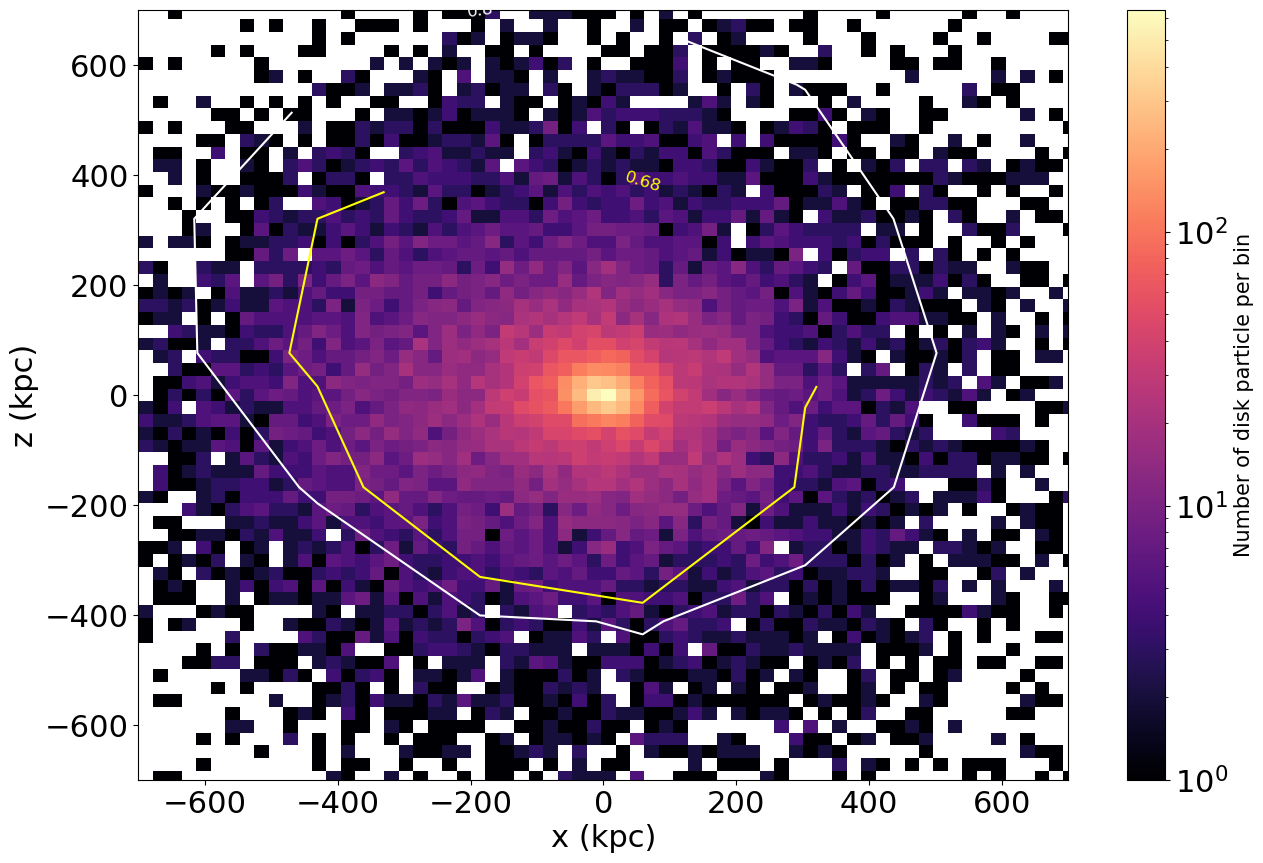

In [23]:
# Rotated M31 Disk - EDGE ON

# M31 Disk Density 
fig, ax= plt.subplots(figsize=(15, 10))

# plot the particle density for M31 , 2D histogram
plt.hist2d(rn[:,0], rn[:,2], bins=900, norm=LogNorm(vmin=1), cmap='magma')
density_contour(rn[:,0], rn[:,1], 80, 80, ax=ax, colors=['yellow', 'red','white', 'yellow'])


cbar = plt.colorbar()
cbar.set_label("Number of disk particle per bin", fontsize=15)


# Add axis labels
plt.xlabel('x (kpc)', fontsize=22)
plt.ylabel('z (kpc)', fontsize=22)

#set axis limits
plt.ylim(-700,700)
plt.xlim(-700,700)

#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size



In [47]:
# make a plot of rotation curve, v vs r in cylindical coord (this may olny use to make sure it have rotation profile)
x, y, z = rn[:,0], rn[:,1], rn[:,2]
vx, vy, vz = vn[:,0], vn[:,1], vn[:,2]

# Cylindrical radius
R = np.sqrt(x**2 + y**2)

# Spherical radius (in case that's what they meant)
r_sph = np.sqrt(x**2 + y**2 + z**2)

# Cylindrical velocity components
v_phi = abs((x * vy - y * vx) / R)
v_R   = (x * vx + y * vy) / R
v_z   = vz

mask = R > 0.1
R = R[mask]
r_sph = r_sph[mask]
v_phi = v_phi[mask]



In [48]:
from scipy.stats import binned_statistic

bins = np.linspace(0, R.max(), 50)
vphi_mean, _, _ = binned_statistic(R, v_phi, statistic='mean', bins=bins)
bin_centers = 0.5 * (bins[1:] + bins[:-1])



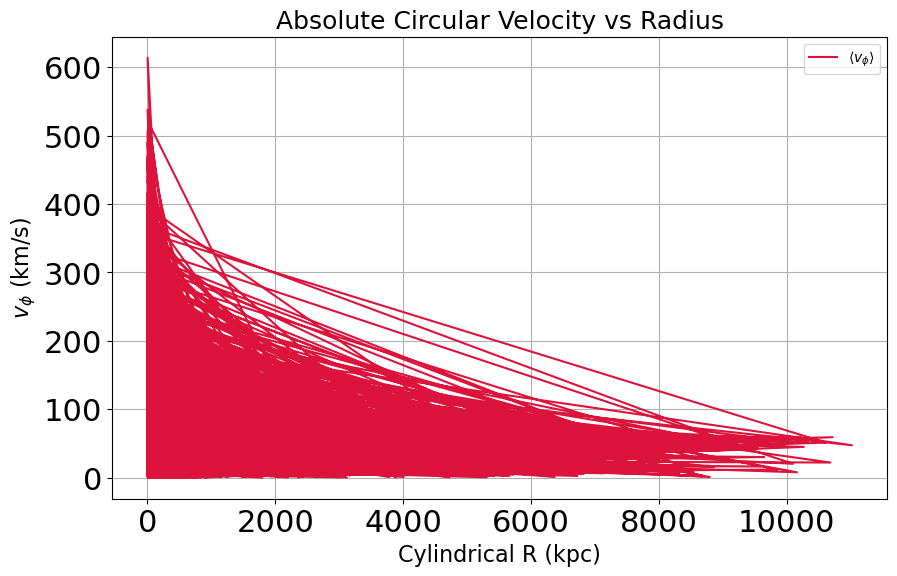

In [51]:
plt.figure(figsize=(10,6))
plt.plot(R, v_phi, label=r"$\langle v_\phi \rangle$", color='crimson')
plt.xlabel(" R (kpc)", fontsize=16)
plt.ylabel(r"$v_\phi$ (km/s)", fontsize=16)
plt.title("Absolute Circular Velocity vs Radius", fontsize=18)
plt.grid(True)
plt.legend()




In [42]:
# decide radius to calculate velocity profile upto. 
# want to use 15kpc or so to capture majority of partilces 



In [10]:
# calculate v/ sigma by using particles in effective radius .
# the actual average circular motions of the particles directly. translate v_x and v_y into v_phi (cylindical) and compute average 

# plot v_phi vs r , plateau is Vmax


# find v ave  with np.mean() 

# sigma with np.std 
